In [126]:
import time
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_absolute_percentage_error, r2_score, root_mean_squared_error
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import mlflow
from matplotlib.colors import LinearSegmentedColormap
from IPython.core.display import HTML
from pylab import rcParams

In [127]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge


# Import data
avo_data = pd.read_csv(r"Data/Avocado_HassAvocadoBoard_20152023.csv", sep=",")

In [128]:
# Filter regions
regions = [
    "California",
    "West",
    "Plains",
    "SouthCentral",
    "Southeast",
    "Midsouth",
    "GreatLakes",
    "Northeast",
]
avo_data = avo_data[avo_data.region.isin(regions)]

In [129]:
# Select only conventional avos
avo_data = avo_data[(avo_data['type'] == 'conventional')]

In [130]:
avo_data

,Date,AveragePrice,TotalVolume,plu4046,plu4225,plu4770,TotalBags,SmallBags,LargeBags,XLargeBags,type,region
12,2015-01-04,0.930000,5777334.90,2843648.26,2267755.26,137479.64,528451.74,477193.38,47882.56,3375.80,conventional,California
30,2015-01-04,1.020000,3382800.12,467259.47,2059657.71,318102.38,537780.56,412779.64,111072.91,13928.01,conventional,GreatLakes
50,2015-01-04,1.100000,2578275.12,575245.44,1311502.53,181058.65,510468.50,429166.89,80986.81,314.80,conventional,Midsouth
58,2015-01-04,1.090000,3759282.62,126640.65,2860709.93,7580.38,764351.66,669970.50,94381.16,0.00,conventional,Northeast
70,2015-01-04,1.010000,1683795.30,1027842.30,466641.12,10476.89,178834.99,177360.20,440.57,1034.22,conventional,Plains
...,...,...,...,...,...,...,...,...,...,...,...,...
53328,2023-12-03,1.155709,4778759.20,881108.32,2409888.29,19657.51,1305651.94,NaN,NaN,NaN,conventional,Northeast
53334,2023-12-03,0.962176,1678947.91,985367.84,251477.35,6024.55,287580.51,NaN,NaN,NaN,conventional,Plains
53345,2023-12-03,0.837357,4733200.48,2731417.86,618149.15,16567.06,674818.76,NaN,NaN,NaN,conventional,SouthCentral
53346,2023-12-03,1.068612,5078814.49,3498598.03,264561.78,545.06,1107991.66,NaN,NaN,NaN,conventional,Southeast


0.43338374513645506 0.933369931624618 271348.5513581769


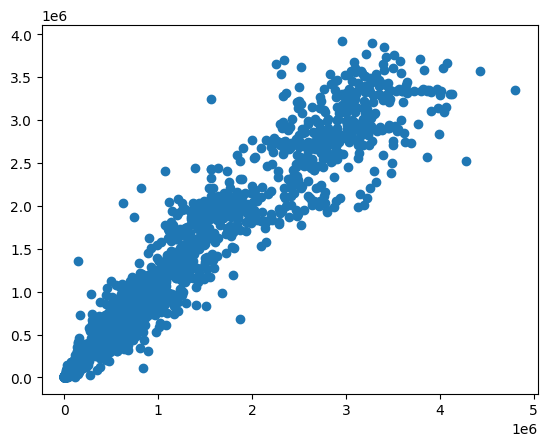

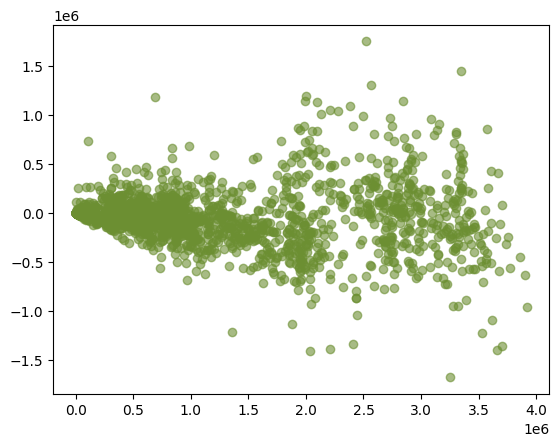

In [131]:
# Ensure the column with date information is in datetime format
avo_data['Date'] = pd.to_datetime(avo_data['Date'])

# Add the index for each year from 2015 to 2022
avo_data['year'] = pd.DatetimeIndex(avo_data['Date']).year
avo_data = avo_data.sort_values(by='Date')

# Define the peak season
peak_months = range(1,8)

def peak_season(row):
    return 1 if int(row['month']) in peak_months else 0

avo_data['month'] = pd.DatetimeIndex(avo_data['Date']).month
avo_data['peak'] = avo_data.apply(lambda row: peak_season(row), axis=1)

# avo_data = avo_data.melt(
#     id_vars=["AveragePrice", "type", "region", "year", "month", "Date", "peak"],
#     value_vars=["plu4046", "plu4225", "plu4770"],
#     var_name="plu",
#     value_name="volume",
# )

# avo_data["prev_volume"] = avo_data.groupby(by=["region", "plu"])['volume'].transform(lambda x: x.shift(1))
# avo_data["prev_total_volume_sold"] = avo_data.groupby(by=["Date", "region"])['volume'].transform('sum').shift(24)
# avo_data["proportion"] = avo_data["prev_volume"] / avo_data["prev_total_volume_sold"]

# Calculate the total volumne for PLU codes only
avo_data['plu_total_volume'] = avo_data['plu4046'] + avo_data['plu4225'] + avo_data['plu4770']

# Get the previous week's sales for that plu code
avo_data['plu4046_prev_volume'] = avo_data.groupby('region')['plu4046'].transform(lambda x: x.shift(1))
avo_data['plu4225_prev_volume'] = avo_data.groupby('region')['plu4225'].transform(lambda x: x.shift(1))
avo_data['plu4770_prev_volume'] = avo_data.groupby('region')['plu4770'].transform(lambda x: x.shift(1))

# Get the previous week's proportion contribution of the plu code to total plu volume sales
avo_data['plu4046_proportion'] = avo_data.groupby('region')['plu4046'].transform(lambda x: x.shift(1)) / avo_data.groupby('region')['plu_total_volume'].transform(lambda x: x.shift(1))
avo_data['plu4225_proportion'] = avo_data.groupby('region')['plu4225'].transform(lambda x: x.shift(1)) / avo_data.groupby('region')['plu_total_volume'].transform(lambda x: x.shift(1))
avo_data['plu4770_proportion'] = avo_data.groupby('region')['plu4770'].transform(lambda x: x.shift(1)) / avo_data.groupby('region')['plu_total_volume'].transform(lambda x: x.shift(1))

# Calculate individual avo plu sales and plu contribution to total sales
avo_data = avo_data.melt(
    id_vars=["AveragePrice", "type", "region", "year", "month", "Date", 'peak'],
    value_vars=["plu4046", "plu4225", "plu4770", "plu4046_prev_volume", "plu4225_prev_volume", "plu4770_prev_volume", "plu4046_proportion", "plu4225_proportion", "plu4770_proportion"],
    var_name="plu",
    value_name="value",
)

# Adjust the PLU code column to keep only the code part
avo_data['plu_type'] = avo_data['plu'].apply(lambda x: 'prev_volume' if 'prev_volume' in x else ('proportion' if 'proportion' in x else 'volume'))
avo_data['plu'] = avo_data['plu'].str.replace('_prev_volume', '').str.replace('_proportion', '')

# Pivot the melted DataFrame to separate 'plu_value', 'prev_volume', and 'proportion' into different columns
avo_data = avo_data.pivot_table(
    index=["AveragePrice", "type", "region", "year", "month", "Date", 'peak', 'plu'], 
    columns='plu_type', 
    values='value'
).reset_index()

# Drop missing values
avo_data = avo_data.dropna(subset=['prev_volume'])

# Select relevant columns
avo_data = avo_data[
    ['Date', 'volume', 'prev_volume', 'plu', 'proportion', 'AveragePrice', 'region', 'year', 'month', 'peak']
].reset_index(drop=True)

avo_data.head(50)
avo_data = avo_data.sort_values(by="Date")

# # Predict sales

X = avo_data[['region', 'AveragePrice', 'year', 'peak', 'prev_volume', 'proportion', 'plu']]
y = avo_data['volume']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, shuffle=False, stratify=None
)

feat_transform = make_column_transformer(
    (OneHotEncoder(drop='first'), ['region', 'plu']),
    (StandardScaler(), ['AveragePrice', 'year', 'prev_volume', 'proportion']),
    ("passthrough", ["peak"]),
    verbose_feature_names_out = False,
    remainder="drop"
)

reg = make_pipeline(feat_transform, RandomForestRegressor())
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mape, r2, rmse)

# Plot actual vs predicted
plt.scatter(x=y_test, y=y_pred)
plt.show()
# Plot residuals
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, color='#6C8F32')
plt.show()

In [132]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8928, 7)
y_train shape: (8928,)
X_test shape: (2232, 7)
y_test shape: (2232,)
